# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

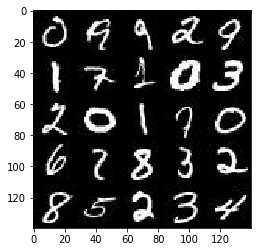

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

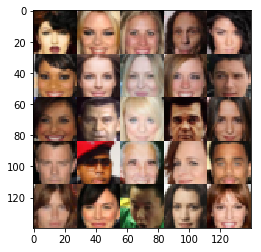

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real'),
            tf.placeholder(tf.float32, (None, z_dim), name='input_z'), 
            tf.placeholder(tf.float32, name='learning_rate'))
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        h = tf.layers.conv2d(h, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 512, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())   
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha*h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        logits = tf.layers.dense(tf.reshape(h, (-1, 7*7*256)), 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('generator', reuse=not is_train):
        h = tf.layers.dense(z, 7*7*512)
        
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d_transpose(h, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        h = tf.layers.conv2d_transpose(h, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
       
        
        h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
       
        logits = tf.layers.conv2d_transpose(h, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
       
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * 0.9))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_count = 0
    
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3649... Generator Loss: 0.2888
Epoch 1/2... Discriminator Loss: 4.0226... Generator Loss: 0.1195
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 2.0755
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 6.3848
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 2.2374
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.8958
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 1.2326
Epoch 1/2... Discriminator Loss: 1.9133... Generator Loss: 0.4989


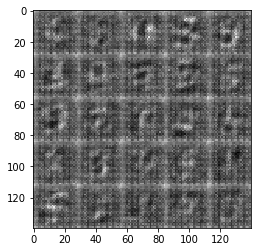

Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 2.6046
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 3.6906
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 2.1267
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 2.9940
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 2.1914
Epoch 1/2... Discriminator Loss: 0.6424... Generator Loss: 2.0438
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 4.7703
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.3731


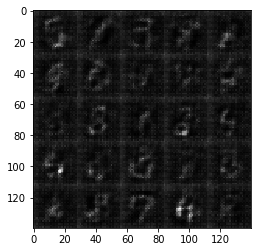

Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 3.0915
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 2.0795
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 2.3982
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.5141
Epoch 1/2... Discriminator Loss: 0.7466... Generator Loss: 3.3039
Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 2.6236
Epoch 1/2... Discriminator Loss: 1.5001... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.9942
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.6612


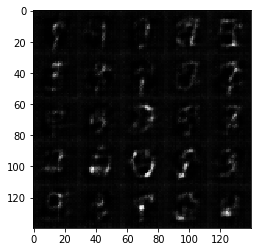

Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.9934
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 2.4176
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 2.1335
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 2.5352
Epoch 1/2... Discriminator Loss: 0.5969... Generator Loss: 3.4294
Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 2.6473
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 2.3521
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 2.4626
Epoch 1/2... Discriminator Loss: 3.5395... Generator Loss: 6.0284
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.3323


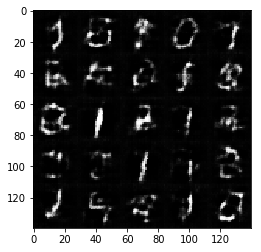

Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.0577
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 2.3358
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.9750
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.4501
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 2.8577
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 1.7490
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 0.9393
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 1.2246


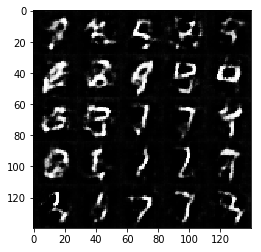

Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 2.0948
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 2.1921
Epoch 1/2... Discriminator Loss: 1.8978... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 2.7005
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 2.0873
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.8237
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 2.0475
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 1.1735


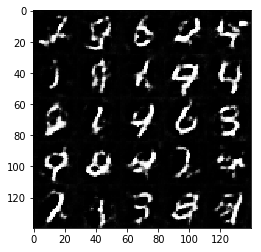

Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 2.5176
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.4856
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 3.0280
Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 2.2277
Epoch 1/2... Discriminator Loss: 3.0982... Generator Loss: 0.1292
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 1.4596
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 2.5428
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 1.3821
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.7899
Epoch 1/2... Discriminator Loss: 0.6596... Generator Loss: 1.6517


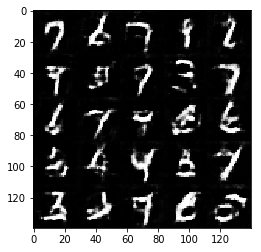

Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 3.0070
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 2.6045
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 3.1180
Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 0.5030
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 2.0840
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 2.3890
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 1.6713


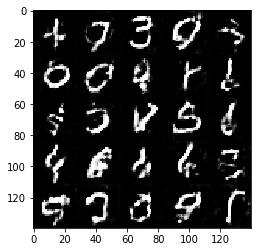

Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 3.0458
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 2.8161
Epoch 1/2... Discriminator Loss: 0.5136... Generator Loss: 2.1689
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 2.3677
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 1.8809
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.5545
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 2.2329
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.9055


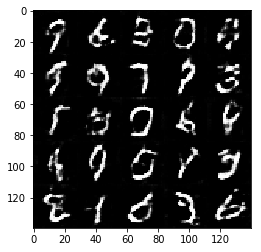

Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 3.5551
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 3.1176
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 2.3524
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.7356
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 2.1801
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 1.9087
Epoch 2/2... Discriminator Loss: 3.6807... Generator Loss: 5.7862
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.4802
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.6292


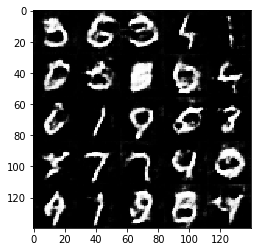

Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 2.8359
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 2.4599
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.9929
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 2.0024
Epoch 2/2... Discriminator Loss: 2.4898... Generator Loss: 0.3302
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.2902
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.6783
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.1332
Epoch 2/2... Discriminator Loss: 0.4733... Generator Loss: 2.8979
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 2.3785


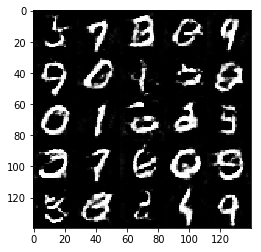

Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 2.1054
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 2.2911
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.6903
Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 2.8203
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 2.1669
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 2.2270
Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 2.3793
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.5768


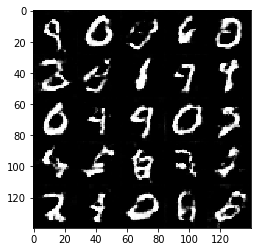

Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 3.4175
Epoch 2/2... Discriminator Loss: 0.6038... Generator Loss: 2.1158
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 0.4907... Generator Loss: 2.1905
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 2.1099
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 3.1848
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 2.6375
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 2.3523
Epoch 2/2... Discriminator Loss: 0.5090... Generator Loss: 2.4812


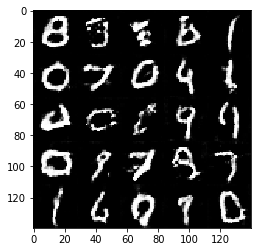

Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 2.7291
Epoch 2/2... Discriminator Loss: 2.3380... Generator Loss: 0.3895
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 4.4578
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.5138
Epoch 2/2... Discriminator Loss: 0.5376... Generator Loss: 1.9294
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.9278
Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.5703
Epoch 2/2... Discriminator Loss: 0.4876... Generator Loss: 2.2808


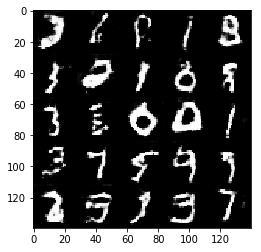

Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 2.6197
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.8638
Epoch 2/2... Discriminator Loss: 0.5251... Generator Loss: 2.4453
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 2.1149
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.6447
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 2.9736
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 2.5269
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 2.1389
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.8534
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.4652


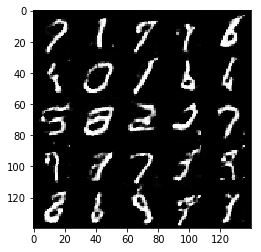

Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 2.3740
Epoch 2/2... Discriminator Loss: 0.5687... Generator Loss: 1.9095
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 2.8151
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.6591
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 2.3939
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.8429
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.3126
Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 2.2492


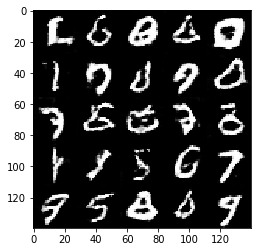

Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 2.7770
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 2.9674
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 3.5171
Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 3.1253
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 3.1919
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 4.1897
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 3.4186
Epoch 2/2... Discriminator Loss: 0.4789... Generator Loss: 2.5822
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 2.5483
Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 2.0679


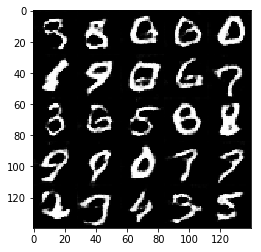

Epoch 2/2... Discriminator Loss: 0.4750... Generator Loss: 2.5608
Epoch 2/2... Discriminator Loss: 0.7378... Generator Loss: 1.7770
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.4651
Epoch 2/2... Discriminator Loss: 2.1497... Generator Loss: 4.1791
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.3392
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 2.6541
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.9250
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 3.1204
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.7479
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 2.2240


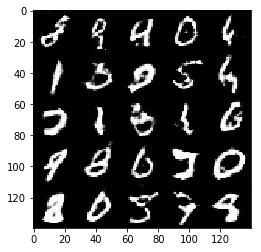

Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 2.5517
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 2.8676
Epoch 2/2... Discriminator Loss: 2.0954... Generator Loss: 4.7433
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 3.2950
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 2.9360


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 4.7435
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 2.1237
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.8609
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 2.1626... Generator Loss: 5.9264
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 3.5511
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 3.2268
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 2.1441
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.8519


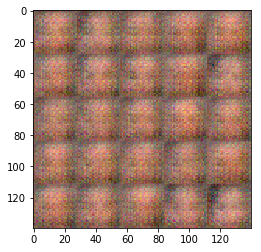

Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 2.1619
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 2.6413
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 2.0854... Generator Loss: 0.3413
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 3.4278
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.4871


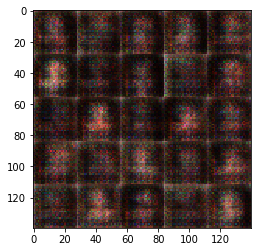

Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 2.2621
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 3.0354
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 2.6473
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.7610
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 2.5336


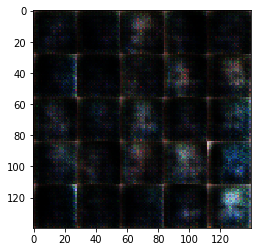

Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.7371
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 2.5780
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 2.8563
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 3.3437
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6655


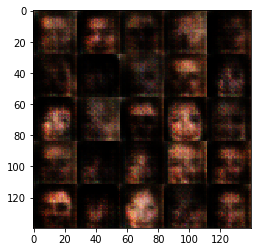

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.8697... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 2.1004
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 2.2859
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 3.2105
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 2.6754
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 2.6171


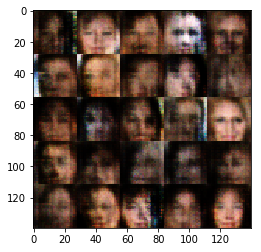

Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 5.0849
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 2.6586
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 2.7477
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.4541
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.2454


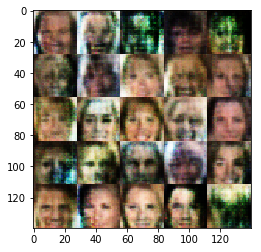

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 2.5417
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 2.7549
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.5997


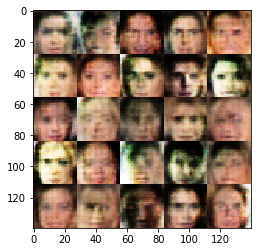

Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 3.7043... Generator Loss: 5.9019
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 2.3989


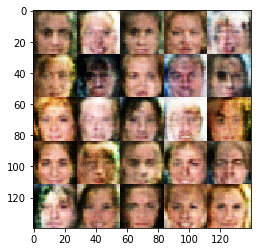

Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 2.1491
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9708


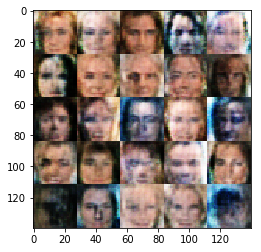

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.7797... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.6996


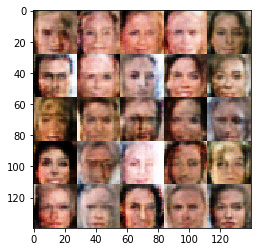

Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.5733
Epoch 1/1... Discriminator Loss: 1.8006... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 2.2495
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 2.2313
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.7836
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.3308


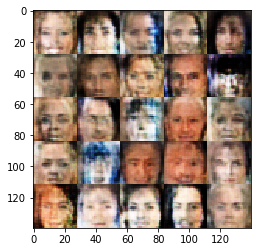

Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.6781... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 1.6032... Generator Loss: 0.4297


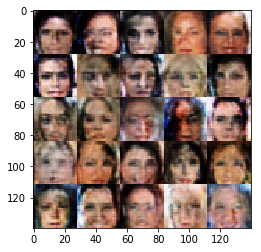

Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 2.0726
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.7071... Generator Loss: 2.8269
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.6314... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.7093


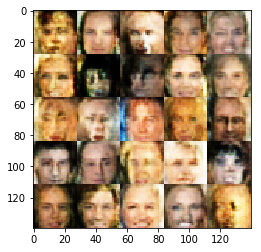

Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 2.8516
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 2.5362


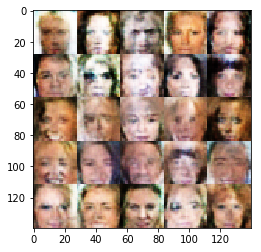

Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8292


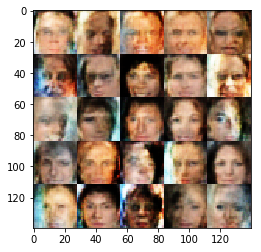

Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 2.7077
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.9508
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.9213
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8797


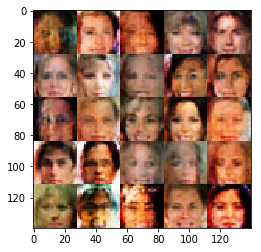

Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 2.4108
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.1008


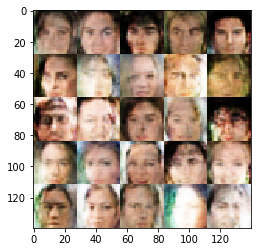

Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.9796
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.9793
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.8975


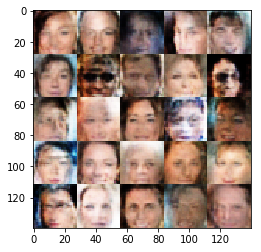

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 2.7175
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.3346
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 2.2771
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 2.6016
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.9266
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 2.0363


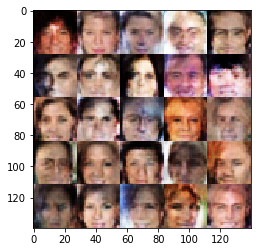

Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 3.2161
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 2.7325
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 1.9943


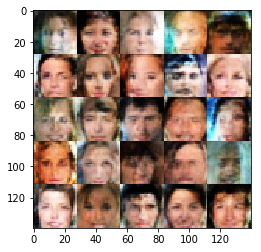

Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 2.5894
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 3.6697
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0124


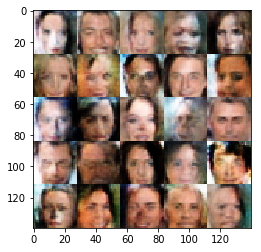

Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.6320
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 4.1884


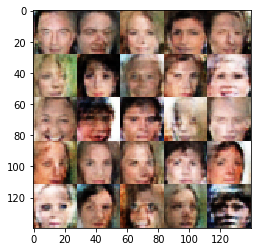

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 3.0092
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 2.5169
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.1731
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.9640


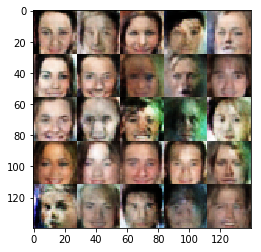

Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.7827
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 2.7879
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 2.5161
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 2.4484
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 3.3170


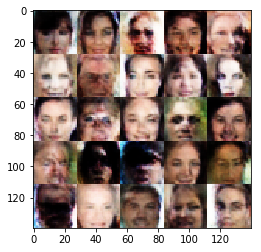

Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 2.0836
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 2.1257
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.9016
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.5548


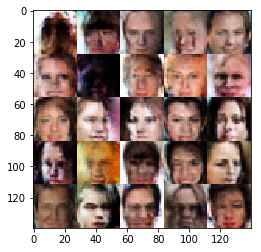

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 2.5196
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 2.5874
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 3.6928
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 2.1786
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.3939


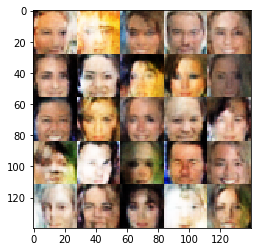

Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 3.6366
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 2.6365
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.8370
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.8769
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 2.2534
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7614


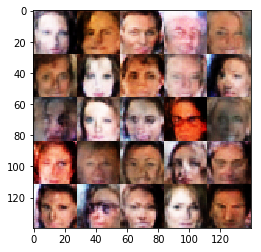

Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 3.1660
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.9283
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.8657
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.5302


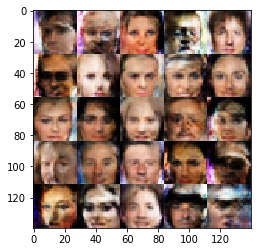

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 3.4570
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.5333
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 3.1778
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 2.3370
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 4.2930
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 3.8374
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 3.9870
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.6549


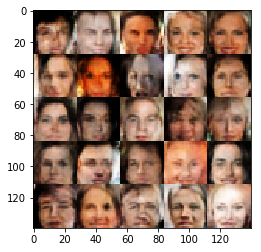

Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.3480
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.9738
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.9196
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 3.0581
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 2.3042


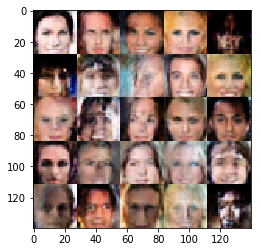

Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 2.2199
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.5556
Epoch 1/1... Discriminator Loss: 2.8181... Generator Loss: 0.2550
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 3.5806
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 2.0100
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.0317
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.6691
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 3.3087


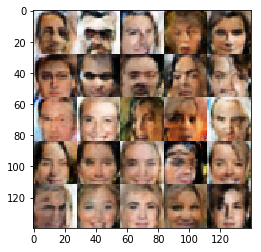

Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 2.5304
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 3.2805


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.